In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
#from pycm import ConfusionMatrix
import json
from molfeat.calc import FPCalculator


In [11]:
# Load the JSON data
data_file = 'extracted_data_with_fp.json'
with open(data_file, 'r') as file:
    data = json.load(file)
    print(data)

def is_within_deviation(actual_product, expected_product, deviation=0.10):
    if expected_product == 0:
        return actual_product == 0
    return abs(actual_product - expected_product) / abs(expected_product) <= deviation


# Analyze the data
for entry in data:
    r1 = entry['r_values'].get('constant_1')
    r2 = entry['r_values'].get('constant_2')
    r_product = entry.get('r-product')
    
    if r_product is None:
        entry['r-product_filter'] = False
        continue
    
    actual_product = r1 * r2
    
    # Check for division by zero
    if r_product == 0:
        deviation = float('inf') if actual_product != 0 else 0
    else:
        deviation = abs(actual_product - r_product) / abs(r_product)
    
    if is_within_deviation(actual_product, r_product):
        entry['r-product_filter'] = False
    else:
        entry['r-product_filter'] = True # reaction should be filtered out

def filter_conf_intervals(row):
    if 'conf_intervals' in row and 'constant_conf_1' in row['conf_intervals'] and 'constant_conf_2' in row['conf_intervals']:
        conf_1 = row['conf_intervals']['constant_conf_1']
        conf_2 = row['conf_intervals']['constant_conf_2']
        
        # Ensure 'r1' and 'r2' are correctly retrieved from the row
        r1 = row.get('r_values', {}).get('constant_1')
        r2 = row.get('r_values', {}).get('constant_2')
        
        if r1 is not None and r2 is not None and conf_1 is not None and conf_2 is not None:
            # Filter condition: Confidence intervals should not be greater than the corresponding r-values
            return (conf_1 <= 1 * r1) and (conf_2 <= 1 * r2)
    
    # If conditions are not met, return True by default, meaning the row will not be filtered out
    return True

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
# Convert JSON data to DataFrame
df_full = pd.DataFrame(data)

print('Initial datapoints: ', len(df_full))
df_full = df_full[df_full.apply(filter_conf_intervals, axis=1)]
print('Datapoints after confidence filter:', len(df_full))

# Separate the filtered data
df_filtered = df_full[df_full['r-product_filter'] == False]

print('Datapoints after r-product filter: ', len(df_filtered))
print(df_filtered)

Initial datapoints:  1138
Datapoints after confidence filter: 1060
Datapoints after r-product filter:  1037
               file                   monomer1_s   monomer2_s  \
0      paper01.json                 C=C(C)C(=O)O  C=Cc1ccccc1   
1      paper01.json                 C=C(C)C(=O)O  C=Cc1ccccc1   
2      paper01.json                 C=C(C)C(=O)O  C=Cc1ccccc1   
3      paper01.json                 C=C(C)C(=O)O  C=Cc1ccccc1   
4      paper01.json                 C=C(C)C(=O)O  C=Cc1ccccc1   
...             ...                          ...          ...   
1133  paper_99.json            C=CC(=O)OCCCCCCCC       C=CC#N   
1134  paper_99.json  C=CC(=O)OCCCCCCCCCCCCCCCCCC       C=CC#N   
1135  paper_99.json                C=CC(=O)OCCCC    C=C(Cl)Cl   
1136  paper_99.json            C=CC(=O)OCCCCCCCC    C=C(Cl)Cl   
1137  paper_99.json  C=CC(=O)OCCCCCCCCCCCCCCCCCC    C=C(Cl)Cl   

                monomer1             monomer2  \
0       methacrylic acid              styrene   
1       metha

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def preprocess_data(df, target_column):
    # Add r1, r2, and r1r2 columns
    df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
    df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
    df['r1r2'] = df['r1'] * df['r2']

    # Filter out rows with NaNs in monomer1, monomer2, or r1r2
    df.dropna(subset=['monomer1', 'monomer2', 'r1r2'], inplace=True)
    
    # Filter out rows where solvent is NaN and method is not 'bulk'
    df = df[~((df['solvent'].isna()) & (df['method'] != 'bulk'))]
    
    print(f"Datapoints after removing None values: {len(df)}")
    
    # Mapping for the 'method' column
    method_mapping = {
        'bulk': 0,
        'Bulk': 0,
        'solvent': 1,
        'Solvent': 1,
        'emulsion': 2,
        'suspension': 3,
        'photopolymerization': 10
    }
    
    # Mapping for 'calculation_method' column
    calculation_method_mapping = {
        'Kelen-Tudor': 0,
        'Fineman-Ross': 1,
        'Fineman and Ross': 1,
        'Fineman Ross method': 1,
        'fundamental equation of copolymerisation': 2,
        'Mayo and Lewis': 3,
        'Mayo-Lewis differential method': 3,
        'Mayo and Lewis method': 3,
        'Mayo and Lewis intersection method': 3,
        'Intersection method': 3,
        'intersection method of Mayo and Lewis': 3,
        'Joshi-Joshi': 4,
        'Schwan and Price': 5,
        'Alfrey-Price': 6,
        'Alfrey and Goldfinger': 6,
        'regression analysis': 7,
        'nonlinear least squares technique': 7,
        'non-linear regression': 7,
        'nonlinear least squares': 7,
        'nonlinear least squares analysis': 7,
        'nonlinear least squares procedure': 7,
        'approximations successives': 7,
        'graphical solution of the copolymerization equation': 8,
        'graphical method of intersections': 8,
        'graphical evaluation': 8,
        'graphical': 8,
        'graphic method': 8,
        'graphic solution': 8,
        'logarithm plot': 9,
        'polarization': 10,
        'Nuclear magnetic resonance spectroscopy': 11,
        'NMR spectroscopy': 11,
        'NMR analysis': 11,
        'carbon elemental analyses': 12,
        'nitrogen analyses': 13,
        'Ghosh-Palit': 14,
        'curve fitting': 15,
        'curve-fitting technique': 15,
        'curve-fitting': 15,
        'Multiparameter correlation equation': 16,
        'Yserielve-Brokhina-Roskin': 17,
        'Yezrielev method': 17,
        'Ezrievlev and co-workers': 17,
        'Shtraikhman approach': 18,
        'differential form of the copolymer equation': 19,
        'penultimate model': 20,
        'penultimate mu model': 20,
        'Alfrey-Price equation': 21,
        'assumed': 22,
        'Optimizer': 23,
        'Barb': 24,
        'previous paper': 30,
        'not provided': 30,
        'not specified': 30,
        'EVM Program': 27,
        'Tidwell-Mortimer': 28,
        'Grant': 29,
        'null': 30
    }

    # Apply the custom mappings
    df['calculation_method_encoded'] = df['calculation_method'].map(calculation_method_mapping)
    df['method_encoded'] = df['method'].map(method_mapping)

    # Remove rows that contain NaN values in the target variable
    df.dropna(subset=[target_column], inplace=True)
    
    # Create a flipped version of the dataframe with monomer1 and monomer2 data swapped
    df_flipped = df.copy()
    df_flipped['monomer1'], df_flipped['monomer2'] = df['monomer2'], df['monomer1']
    df_flipped['fingerprint_1'], df_flipped['fingerprint_2'] = df['fingerprint_2'], df['fingerprint_1']
    
    # Combine the original and flipped dataframes
    df = pd.concat([df, df_flipped], ignore_index=True)

    # Combine fingerprints and other features into a feature matrix
    monomer1_fps = np.vstack(df['fingerprint_1'].values)
    monomer2_fps = np.vstack(df['fingerprint_2'].values)
    solvent_fps = np.vstack(df['solvent_fingerprint'].values)
    
    expected_length = 2048  # Assuming each fingerprint should be 2048 bits long
    
    temperature = df['temperature'].values.reshape(-1, 1)
    method_features = df['method_encoded'].values.reshape(-1, 1)
    calculation_method_features = df['calculation_method_encoded'].values.reshape(-1, 1)

    # Combine all features into a single array
    all_features = np.hstack([monomer1_fps, monomer2_fps, solvent_fps, temperature, method_features, calculation_method_features])

    # Handle any remaining NaN values by imputing them with the column mean
    imputer = SimpleImputer(strategy='mean')
    all_features = imputer.fit_transform(all_features)
    
    # Normalization step
    scaler = StandardScaler()
    all_features = scaler.fit_transform(all_features)

    # Continuous target variable for regression
    regression_labels = df[target_column].values

    return all_features, regression_labels


In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap

# Define the power transformer for the label
pt = PowerTransformer(method='yeo-johnson')

# Preprocess the data
all_features, regression_labels = preprocess_data(df_filtered, target_column='r1r2')

# Implement K-Fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_scores = []

all_y_true = []
all_y_pred = []
all_y_train_true = []
all_y_train_pred = []

for fold, (train_idx, test_idx) in enumerate(kf.split(all_features), 1):
    print(f"Fold {fold}")
    
    # Split the data
    X_train, X_test = all_features[train_idx], all_features[test_idx]
    y_train, y_test = regression_labels[train_idx], regression_labels[test_idx]
    
    # Transform the label
    y_train_transformed = pt.fit_transform(y_train.reshape(-1, 1)).ravel()
    y_test_transformed = pt.transform(y_test.reshape(-1, 1)).ravel()
    
    # Define the model with default parameters or specified parameters
    model = XGBRegressor(
        n_estimators=1000,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        gamma=0,
        random_state=42
    )
    
    # Train the model
    model.fit(X_train, y_train_transformed, 
              eval_set=[(X_test, y_test_transformed)], 
              verbose=False)
    
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Store true and predicted values for train
    all_y_train_true.extend(y_train_transformed)
    all_y_train_pred.extend(y_pred_train)
    
    # Store true and predicted values for test
    all_y_true.extend(y_test_transformed)
    all_y_pred.extend(y_pred_test)
    
    # Calculate metrics
    mse_train = mean_squared_error(y_train_transformed, y_pred_train)
    r2_train = r2_score(y_train_transformed, y_pred_train)
    mse_test = mean_squared_error(y_test_transformed, y_pred_test)
    r2_test = r2_score(y_test_transformed, y_pred_test)
    
    print(f"Train MSE: {mse_train:.4f}, Train R2: {r2_train:.4f}")
    print(f"Test MSE: {mse_test:.4f}, Test R2: {r2_test:.4f}")
    
    fold_scores.append((r2_train, r2_test))

# Calculate average scores across all folds
avg_train_r2 = np.mean([score[0] for score in fold_scores])
avg_test_r2 = np.mean([score[1] for score in fold_scores])

print(f"\nAverage Train R2: {avg_train_r2:.4f}")
print(f"Average Test R2: {avg_test_r2:.4f}")


/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_25919/2510065860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_25919/2510065860.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
/var/folders/tv/b0y73fwd4zn4

Datapoints after removing None values: 1002
Fold 1
Train MSE: 0.1601, Train R2: 0.4042
Test MSE: 0.1889, Test R2: 0.2493
Fold 2
Train MSE: 0.1668, Train R2: 0.3882
Test MSE: 0.1378, Test R2: 0.3660
Fold 3
Train MSE: 0.1656, Train R2: 0.4084
Test MSE: 0.1932, Test R2: -0.2752
Fold 4
Train MSE: 0.1560, Train R2: 0.4026
Test MSE: 0.2503, Test R2: 0.2198
Fold 5
Train MSE: 0.1614, Train R2: 0.4245
Test MSE: 0.1950, Test R2: -0.3359
Fold 6
Train MSE: 0.1579, Train R2: 0.4115
Test MSE: 0.2066, Test R2: 0.1822
Fold 7
Train MSE: 0.1514, Train R2: 0.3757
Test MSE: 0.2776, Test R2: 0.4313
Fold 8
Train MSE: 0.1669, Train R2: 0.3970
Test MSE: 0.1221, Test R2: 0.3228
Fold 9
Train MSE: 0.1664, Train R2: 0.3625
Test MSE: 0.1283, Test R2: 0.5998
Fold 10
Train MSE: 0.1538, Train R2: 0.4069
Test MSE: 0.2420, Test R2: 0.2813

Average Train R2: 0.3982
Average Test R2: 0.2041


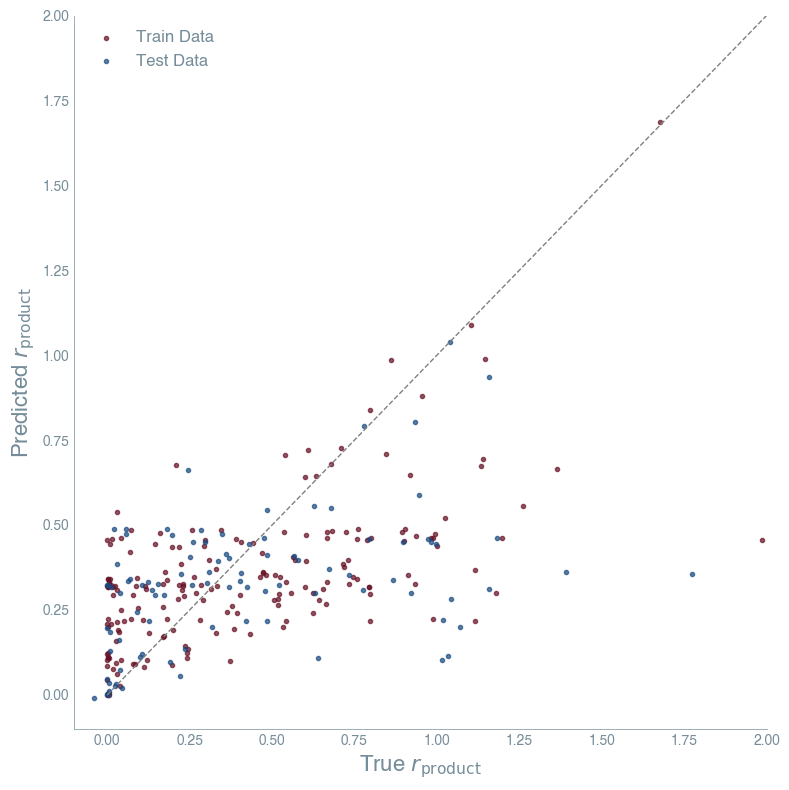

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Random selection of 200 train datapoints
train_indices = np.random.choice(len(all_y_train_true), 200, replace=False)
selected_y_train_true = np.array(all_y_train_true)[train_indices]
selected_y_train_pred = np.array(all_y_train_pred)[train_indices]

# Random selection of 100 test datapoints
test_indices = np.random.choice(len(all_y_true), 100, replace=False)
selected_y_true = np.array(all_y_true)[test_indices]
selected_y_pred = np.array(all_y_pred)[test_indices]

selected_y_train_true_inv = pt.inverse_transform(np.array(selected_y_train_true).reshape(-1, 1)).ravel()
selected_y_train_pred_inv = pt.inverse_transform(np.array(selected_y_train_pred).reshape(-1, 1)).ravel()

selected_y_true_inv = pt.inverse_transform(np.array(selected_y_true).reshape(-1, 1)).ravel()
selected_y_pred_inv = pt.inverse_transform(np.array(selected_y_pred).reshape(-1, 1)).ravel()

plt.figure(figsize=(8, 8))

plt.style.use('../data_extraction/plots_and_figures/lamalab.mplstyle')

plt.scatter(selected_y_train_true_inv, selected_y_train_pred_inv, alpha=0.7, label='Train Data', color='#661124')
plt.plot([min(selected_y_train_true_inv), max(selected_y_train_true_inv)], 
         [min(selected_y_train_true_inv), max(selected_y_train_true_inv)], 
         color='grey', linestyle='--')  # Linie y=x

plt.scatter(selected_y_true_inv, selected_y_pred_inv, alpha=0.7, label='Test Data', color='#194A81')
plt.xlabel(r'True $r_{\text{product}}$', fontsize=16)
plt.ylabel(r'Predicted $r_{\text{product}}$', fontsize=16)
plt.xlim(-0.1, 2)
plt.ylim((-0.1,2))
plt.legend(fontsize=12)

plt.grid(False)
plt.tight_layout()
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

plt.savefig('pred_200_XGBoost_fp.pdf', dpi=300, bbox_inches='tight')
plt.show()